In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [190]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [191]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


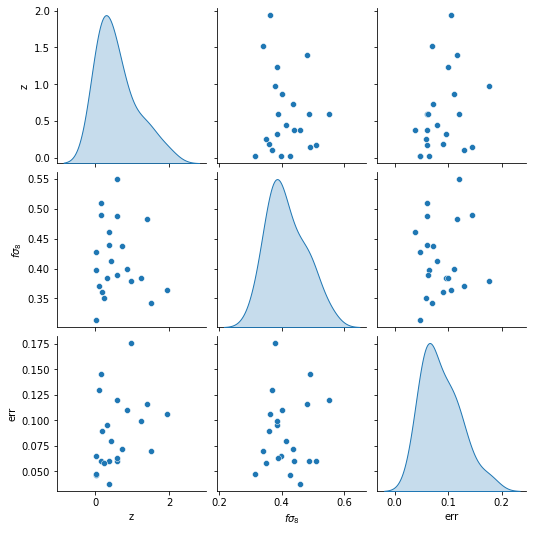

In [192]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [193]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [194]:
z = data[:,0]
y = data[:,1:]
# print(randomize)
np.max(z)

1.944

In [195]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [196]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [197]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [198]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_37 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_38 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [199]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 100

In [200]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0757 - val_loss: 0.0227
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0139
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0107
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 11/

17/17 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 83/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 84/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 85/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 86/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 87/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 88/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 89/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 90/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 91/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 92/100


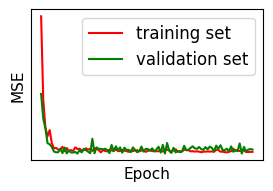

In [201]:
# plt.plot(model_train.history['loss'], color='r', )
# plt.plot(model_train.history['val_loss'], color='g')
# plt.ylabel('MSE')
# plt.xlabel('Epoch')
# # plt.xscale('log')
# plt.xlim(0)
# plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
plt.savefig('loss_fs8.png')


In [202]:
# neural_model.save("FFNN_fs8.h5")

In [203]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e
# 0.002703879727050662 0.0013360671000555158 20e
### 100
# 0.001952524995431304 0.0008627769420854747
# 0.001952524995431304 0.002966993721202016
dif_loss = model_train.history['val_loss'][-1] - model_train.history['val_loss'][-2]
val_loss = model_train.history['val_loss'][-1]
dif_loss, val_loss

0.002126048319041729 0.0016918566543608904
0.002285552443936467 0.0031080294866114855


(-0.00019812211394309998, 0.0031080294866114855)

In [204]:
pred = neural_model.predict(z_test)
pred

array([[0.44951186, 0.07288726],
       [0.48389718, 0.08292866],
       [0.47624668, 0.08047396],
       [0.459891  , 0.08676814],
       [0.4098504 , 0.10978818]], dtype=float32)

In [205]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [216]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


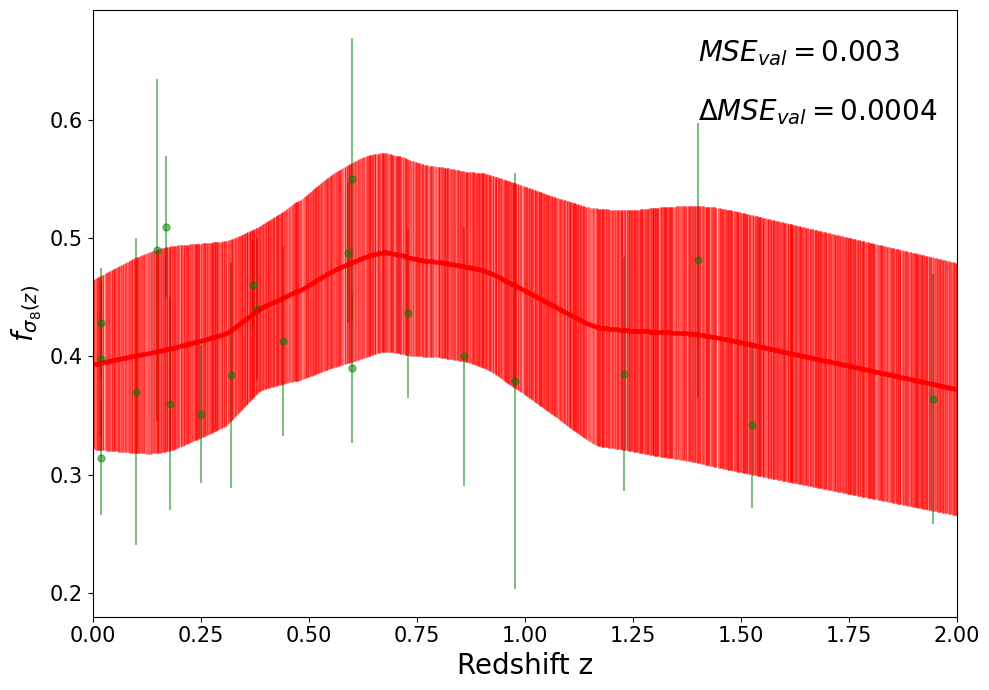

In [217]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.1, c='r',)
plt.ylabel("$f_{\sigma_8(z)}$", fontsize=20)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.text( 1.4, 0.65, "$MSE_{val} = 0.003$", fontsize=20 )
plt.text( 1.4, 0.6, "$\Delta MSE_{val} = 0.0004$", fontsize=20 )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.legend(loc='upper right')
# plt.legend()
plt.savefig("synthetic_fs8_1000.png")

In [218]:
from functools import partial
# Cosmological constants
Om = 0.342
# variance network
s8 = 0.8
h = 1
# def Ezlcdm(a):
#     return np.sqrt(Om*(1/a)**3 + 1 - Om)

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
# #     return Om*(1/a)**3 + 1 - Om
#     w0 = -1.0
#     wa = 0.0
#     rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
#     return (Om/a**3+(1.0-Om)*rhow)

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return h**2*(Om/a**3+(1.0-Om)*rhow)

  
# def growth_lcdm(z):
#     # Equation 7.77 from Doddie
#     af = 1./(1. + z)
#     r = intg.quad(GrowthIntegrand_a_lcdm, 1e-7, af)
#     gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
#     gr *= 5/2.*Om
#     return gr
    

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_owacdm(af, w0, wa))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

# # returns the growth factor as a function of redshift
# def GrowthIntegrand_a_lcdm(a):
#     rhsquareda = RHSquared_a_lcdm(a) 
#     return 1./(rhsquareda*a*a)**(1.5)

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)

# def fs8lcdm(z):
#     return -s8*(1+z)*derivative(growth_lcdm, z, dx=1e-6)/growth_lcdm(0)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)

In [219]:
z = np.linspace(0.0, 2, 1000)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []
fowacdm4 = []

# flcdm = []
for zz in z:
#     flcdm.append(fs8lcdm(zz))
    flcdm.append(fs8owacdm(zz, w0=-1, wa=0.0))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-0.8, wa=-0.4))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)

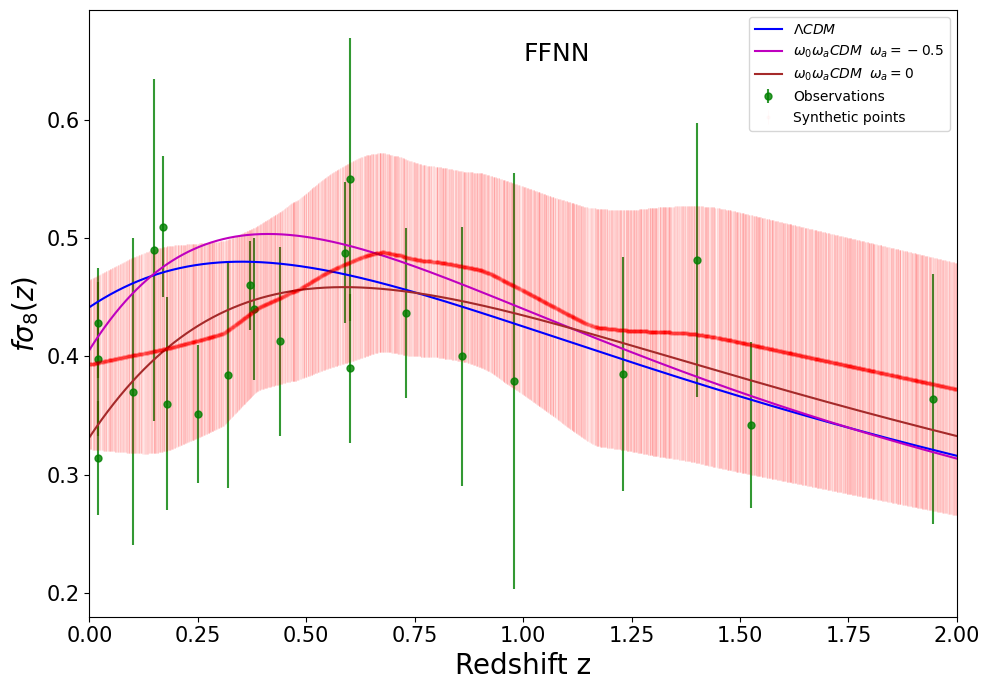

In [228]:
plt.figure(figsize=(10, 7), dpi=100)

z = np.linspace(0, 2, 1000)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.02, c='r',)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='m')
plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')
plt.text(1,0.65,'FFNN', fontsize=18)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("$f\sigma_8(z)$", fontsize=20)
plt.tight_layout()
plt.legend()

plt.savefig("Syntheticfs8.png",dpi=100)

In [211]:
# pred_random.shape, r.shape

In [215]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

IndexError: index 2960 is out of bounds for axis 0 with size 1000

In [ ]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [ ]:
mookHz

In [ ]:
predy_reduced[:,1]

In [ ]:
error  = predy_reduced[:,1]**2
error

In [103]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

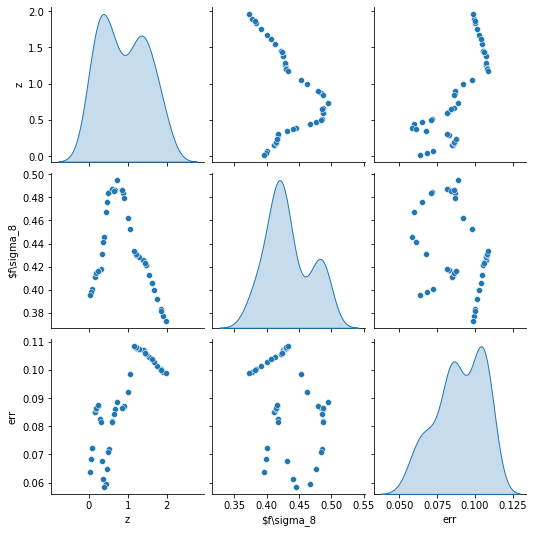

In [104]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [33]:
from astroNN.nn.layers import MCDropout

In [34]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((80,), (22, 1), (20,), (0, 1))

In [35]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model2 = model_regression_dropout(num_hidden=[100, 50, 50])
model2.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model2.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/2000
5/5 [==============================] - 0s 25ms/step - loss: 0.0869 - val_loss: 0.0871
Epoch 2/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0864 - val_loss: 0.1057
Epoch 3/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0775 - val_loss: 0.0815
Epoch 4/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0741 - val_loss: 0.0769
Epoch 5/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0752 - val_loss: 0.0833
Epoch 6/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0737 - val_loss: 0.0825
Epoch 7/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0621 - val_loss: 0.0645
Epoch 8/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0670 - val_loss: 0.0670
Epoch 9/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0577 - val_loss: 0.0598
Epoch 10/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0460 - val_loss: 0.0574
Epoch 11/2000
5/5 

Epoch 84/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0120
Epoch 85/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 86/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 87/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.0098
Epoch 88/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0115 - val_loss: 0.0086
Epoch 89/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0145
Epoch 90/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.0085
Epoch 91/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 92/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0144
Epoch 93/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 94/2

5/5 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 167/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 168/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0037
Epoch 169/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 170/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 171/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0141
Epoch 172/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0043
Epoch 173/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.0065
Epoch 174/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0069
Epoch 175/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 176/2000


Epoch 248/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 249/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 250/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 251/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 252/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0017
Epoch 253/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 254/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 255/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 256/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 257/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0047


Epoch 330/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 331/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 332/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 333/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 334/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 335/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0074
Epoch 336/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 337/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 338/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 339/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0021


Epoch 412/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 413/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 414/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 415/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 416/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0073
Epoch 417/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 418/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 419/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 420/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 421/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0030


Epoch 494/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 495/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 496/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 497/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 498/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 499/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 500/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 501/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 502/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 503/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0015


5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 658/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 659/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 660/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 661/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 662/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 663/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 664/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 665/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 666/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 667/2000


5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 740/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 741/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 742/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 743/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 744/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 745/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 746/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 747/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 748/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 749/2000


5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 822/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 9.2528e-04
Epoch 823/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 824/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 825/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 826/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 827/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 828/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 829/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 830/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 831/2

5/5 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 904/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 905/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 906/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 907/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 908/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 909/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 910/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 911/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 912/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 913/2000


Epoch 985/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 986/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 4.6397e-04
Epoch 987/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 988/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 989/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 990/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 991/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 992/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 993/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 994/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0

5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 1067/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 1068/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 1069/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1070/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 1071/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 1072/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 1073/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 1074/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 1075/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 1229/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 1230/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 1231/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 1232/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 1233/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1234/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 1235/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 1236/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 1237/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 9.4641e-04
Ep

5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 1391/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1392/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 1393/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 1394/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 1395/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 1396/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 1397/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 1398/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 1399/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 1553/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 1554/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 1555/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 1556/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 1557/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1558/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 1559/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 1560/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 1561/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 1715/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 1716/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 1717/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 1718/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 1719/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 1720/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 1721/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 1722/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 1723/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 1877/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 1878/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1879/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 1880/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 1881/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 1882/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 1883/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 1884/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 1885/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 

In [36]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [37]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.02752031650269758, 0.01373080040243803)

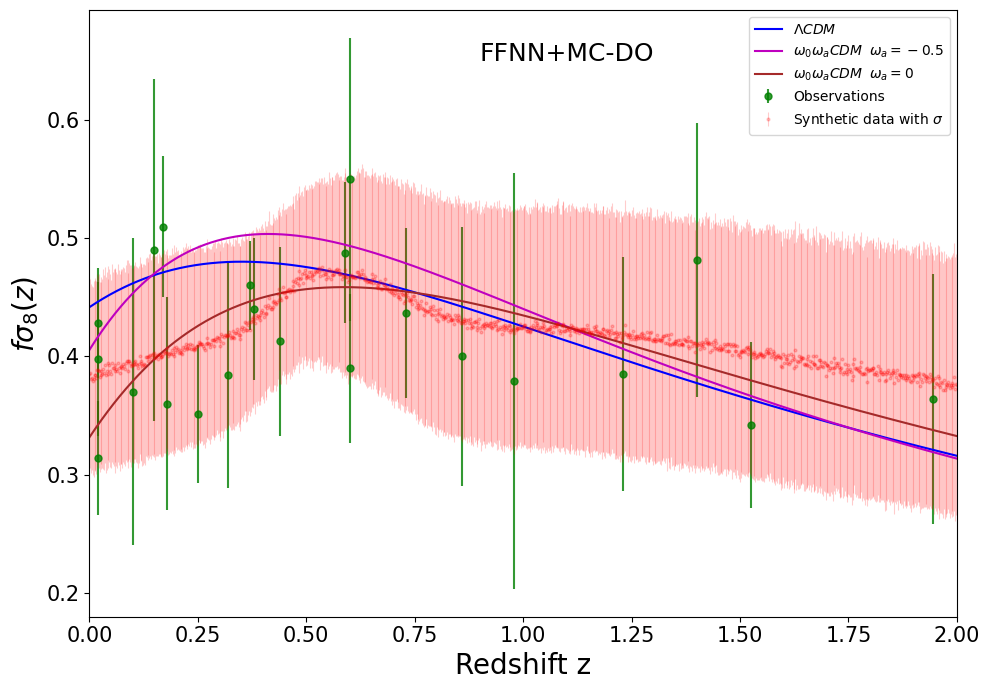

In [229]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.2, c='r',
             label='Synthetic data with $\sigma$')




plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='m')
plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')
plt.text(0.9,0.65,'FFNN+MC-DO', fontsize=18)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("$f\sigma_8(z)$", fontsize=20)
plt.tight_layout()
plt.legend()


plt.savefig('fs8_dropoutb.png', dpi=100)

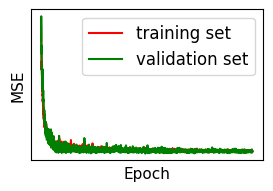

In [114]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
plt.savefig('loss_fs8_DO.png')

In [44]:
tf.keras.models.save_model(model2, '../models/FFNN_MC_DO_Hz.h5' )

In [41]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [42]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

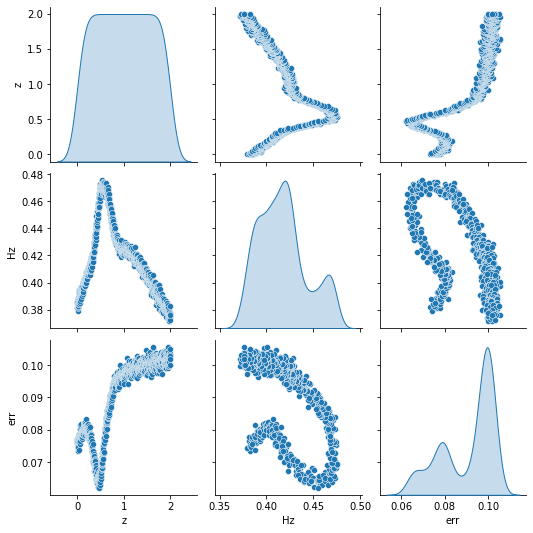

In [43]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")